# Feature Extractor/Reverse Image Search for Album Artwork
This is an implementation of the [Ml4A tutorial](https://github.com/ml4a/ml4a-guides/blob/master/notebooks/image-search.ipynb) on Feature Extraction and Reverse Image Search. The code is largely from there with a set of images provided by me. The notebook goes over how to set up feature extraction just like the original tutorial. Additionally at the end I made the pca features downloadable so that they can be used outside of the notebook.

In [0]:
mkdir images

In [0]:
mv images.zip images/

In [3]:
cd images

/content/images


In [0]:
!unzip images.zip

In [0]:
rm images.zip

In [6]:
cd ..

/content


In [0]:
import os 
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from PIL import Image

import random
from scipy.spatial import distance
from google.colab import files

In [8]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)

Instructions for updating:
Colocations handled automatically by placer.
553467904/553467096 [==============================] - 6s 0us/step


In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
def load_image(path):
  img = image.load_img(path, target_size=model.input_shape[1:3])
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  return img, x

shape of x:  (1, 224, 224, 3)
data type:  float32


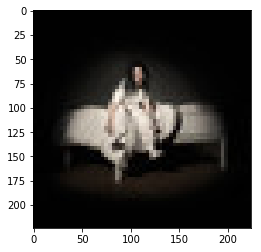

In [11]:
img, x = load_image("images/0.jpeg")
print("shape of x: ", x.shape)
print("data type: ", x.dtype)
plt.imshow(img)

In [12]:
predictions = model.predict(x)
for _, pred, prob in decode_predictions(predictions)[0]:
  print("predicted %s with a probabilty of %0.3f" % (pred, prob))

40960/35363 [==================================] - 0s 0us/step
predicted castle with a probabilty of 0.156
predicted church with a probabilty of 0.128
predicted beacon with a probabilty of 0.105
predicted bell_cote with a probabilty of 0.079
predicted monastery with a probabilty of 0.062


In [13]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

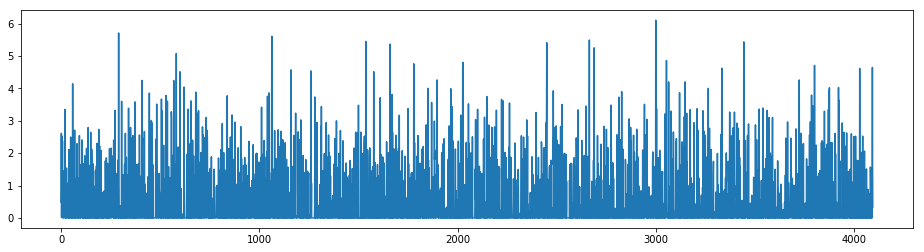

In [14]:
img,x = load_image("images/0.jpeg")
feat = feat_extractor.predict(x)

plt.figure(figsize=(16,4))
plt.plot(feat[0])

In [15]:
path = "images"
images = []

for img in sorted(os.listdir(path)):
  img_path = os.path.join(path,img)
  images.append(img_path)

print(images)

['images/0.jpeg', 'images/1.jpeg', 'images/10.jpeg', 'images/100.jpeg', 'images/101.jpeg', 'images/102.jpeg', 'images/103.jpeg', 'images/104.jpeg', 'images/105.jpeg', 'images/106.jpeg', 'images/107.jpeg', 'images/108.jpeg', 'images/109.jpeg', 'images/11.jpeg', 'images/110.jpeg', 'images/111.jpeg', 'images/112.jpeg', 'images/113.jpeg', 'images/114.jpeg', 'images/115.jpeg', 'images/116.jpeg', 'images/117.jpeg', 'images/118.jpeg', 'images/119.jpeg', 'images/12.jpeg', 'images/120.jpeg', 'images/121.jpeg', 'images/122.jpeg', 'images/123.jpeg', 'images/124.jpeg', 'images/125.jpeg', 'images/126.jpeg', 'images/127.jpeg', 'images/128.jpeg', 'images/129.jpeg', 'images/13.jpeg', 'images/130.jpeg', 'images/131.jpeg', 'images/132.jpeg', 'images/133.jpeg', 'images/134.jpeg', 'images/135.jpeg', 'images/136.jpeg', 'images/137.jpeg', 'images/138.jpeg', 'images/139.jpeg', 'images/14.jpeg', 'images/140.jpeg', 'images/141.jpeg', 'images/142.jpeg', 'images/143.jpeg', 'images/144.jpeg', 'images/145.jpeg', '

In [0]:
features = []

for img in images:
  img,x = load_image(img)
  feat = feat_extractor.predict(x)[0]
  features.append(feat)

In [17]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)

PCA(copy=True, iterated_power='auto', n_components=300, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [0]:
pca_features = pca.transform(features)

In [0]:
def select_image(img_bank):
  
  query_image_idx = int(len(img_bank) * random.random())
  
  img = image.load_img(img_bank[query_image_idx])
  plt.imshow(img)
  
  return query_image_idx

In [0]:
def find_similar(idx, img_bank):
  
  similar_idx = [distance.cosine(pca_features[idx], feat) for feat in pca_features]
  idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:6]
  
  thumbs = []
  for i in idx_closest:
    img = image.load_img(img_bank[i])
    img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)
  
  concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)


  plt.figure(figsize = (16,12))
  plt.imshow(concat_image)

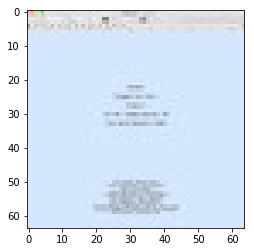

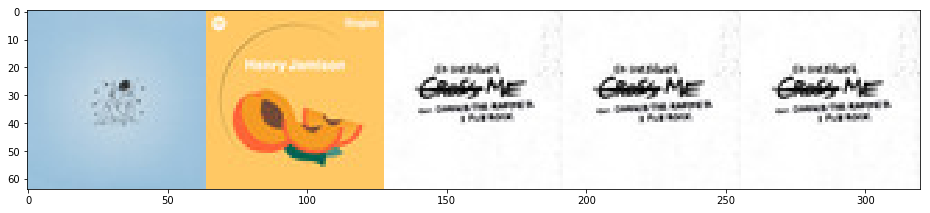

In [21]:
query = select_image(images)
find_similar(query, images)

In [0]:
np.save('album_pca_features', pca_features)

In [0]:
files.download('album_pca_features.npy')